In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import cv2

In [2]:
model = models.resnet50(pretrained = True).to("cuda").eval()
model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
def resnet_feature_extract(image, model, layers=None):
    if layers is None:
        layers = {
            "conv1": "conv1",
            "layer1": "layer1",
            "layer2": "layer2",
            "layer3": "layer3",
            "layer4": "layer4"
        }

    features = {}
    x = model.conv1(image)
    x = model.bn1(x)
    x = model.relu(x)
    features["conv1"] = x

    x = model.maxpool(x)
    x = model.layer1(x)
    features["layer1"] = x

    x = model.layer2(x)
    features["layer2"] = x

    x = model.layer3(x)
    features["layer3"] = x

    x = model.layer4(x)
    features["layer4"] = x

    return features


In [5]:
# model = model.features

In [6]:
count = 0
for parameter in model.parameters():
  count += 1

print(count)

161


In [7]:
# Freeze gradients because we do not need to update them.
for parameter in model.parameters():
  parameter.requires_grad_(False)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
def preprocess_image(img_path, max_size = 400, shape = None):

    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    # print(image.size) 640 * 640

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))]) # ImageNet standard AVG. and Variance
    image = transform(image).unsqueeze(0)

    return image

torch.Size([1, 3, 400, 400])


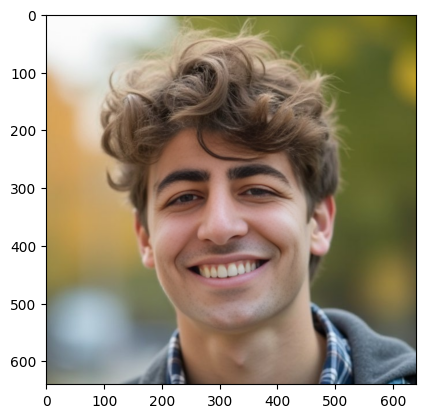

In [11]:
main_img = preprocess_image("1.jpg").to(device)
print(main_img.shape)

torch.Size([1, 3, 400, 400])


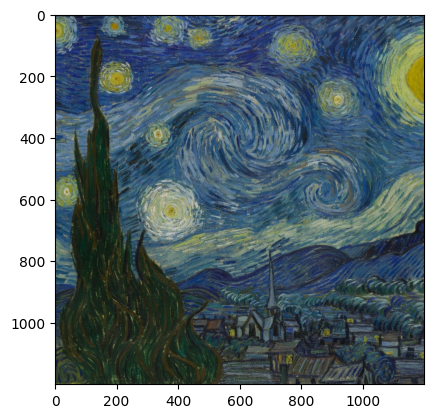

In [12]:
style_img = preprocess_image("2.jpg", shape=main_img.shape[2:]).to(device) # Resize the style image to match the main image.
print(style_img.shape)

In [13]:
# Reverse notmalizing
def converter(tensor):
  img = tensor.clone().detach()
  img = img.numpy().squeeze() # Delete the batch dimension
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # Undo normalization
  img = img.clip(0, 1)

  return img

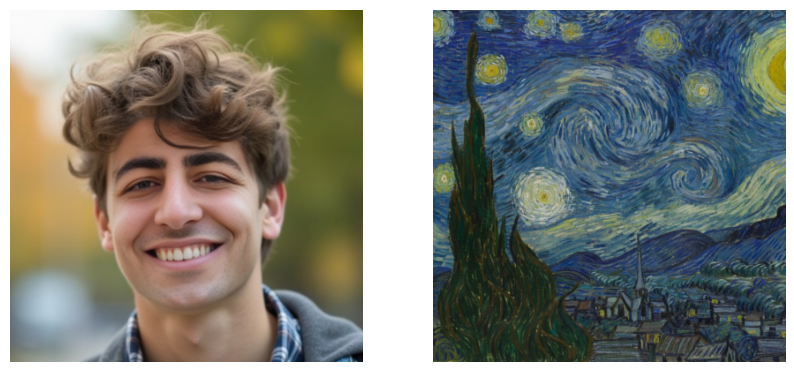

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(converter(main_img.cpu()))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(converter(style_img.cpu()))
plt.axis("off");

In [15]:
model = model.to("cuda")
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def feature_extract(image, model, layers=None):

    if layers is None:
        layers = {
            "0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2",
            "28": "conv5_1"
            }


    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [17]:
# Calculate the gram matrix.
# Gram is a way to describe the style of an image.

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t()) # Product of tensor and its transpose to calculate correlation.
    return gram

In [18]:
main_features = resnet_feature_extract(main_img, model)
main_features

{'conv1': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.9947e-01,
            7.0175e-01, 4.4758e-01],
           [1.1442e-01, 9.4234e-02, 8.1869e-02,  ..., 2.9333e-01,
            2.9566e-01, 3.1467e-01],
           [1.6033e-01, 1.5865e-01, 1.3131e-01,  ..., 2.7605e-01,
            2.7611e-01, 2.9215e-01],
           ...,
           [2.3382e-01, 2.2331e-01, 2.1062e-01,  ..., 3.1116e-01,
            2.9395e-01, 3.2719e-01],
           [2.3030e-01, 2.4447e-01, 2.3218e-01,  ..., 4.3088e-01,
            2.9327e-01, 3.1684e-01],
           [1.7969e-01, 1.5828e-01, 1.4668e-01,  ..., 7.8845e-01,
            8.7791e-01, 1.0697e+00]],
 
          [[6.6021e-01, 6.5876e-01, 6.8326e-01,  ..., 9.2266e-01,
            9.2231e-01, 7.8774e-01],
           [6.7881e-01, 6.9061e-01, 7.1863e-01,  ..., 9.4063e-01,
            9.3994e-01, 7.9271e-01],
           [6.9646e-01, 7.1200e-01, 7.4376e-01,  ..., 8.9333e-01,
            8.9249e-01, 7.5919e-01],
           ...,
           [7.1874e-01, 7.281

In [19]:
style_features = resnet_feature_extract(style_img, model)
style_features

{'conv1': tensor([[[[0.0741, 0.0000, 0.0000,  ..., 0.7380, 0.5927, 0.2263],
           [0.3410, 0.4193, 0.5227,  ..., 0.1168, 0.4693, 0.3376],
           [0.2746, 0.3520, 0.3418,  ..., 0.0499, 0.1002, 0.3284],
           ...,
           [0.2091, 0.2689, 0.2995,  ..., 0.0965, 0.2412, 0.3459],
           [0.3012, 0.2648, 0.4033,  ..., 0.1405, 0.1427, 0.2974],
           [0.3566, 0.4751, 0.5086,  ..., 0.6016, 0.4734, 0.5042]],
 
          [[0.7465, 0.8076, 0.8309,  ..., 0.6866, 0.6667, 0.6407],
           [0.8152, 0.8827, 0.8698,  ..., 0.7493, 0.6867, 0.6318],
           [0.8707, 0.9134, 0.8836,  ..., 0.7780, 0.7073, 0.6325],
           ...,
           [0.7775, 0.6883, 0.6426,  ..., 0.6051, 0.6025, 0.5821],
           [0.7870, 0.7460, 0.6478,  ..., 0.6068, 0.6055, 0.5852],
           [0.7558, 0.7628, 0.6768,  ..., 0.6046, 0.6078, 0.5952]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0385, 0.0725],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0411],
           [0.0

In [21]:
style_grams = {layer : gram_matrix(style_features[layer]) for layer in style_features}
style_grams

{'conv1': tensor([[ 3042.5098,  6909.9971,   844.6087,  ...,  2214.0261, 11238.1484,
           2192.6292],
         [ 6909.9971, 22727.4043,  2157.4539,  ...,  6635.7983, 34737.8828,
           7178.1938],
         [  844.6087,  2157.4539,   774.3264,  ...,   786.9722,  3801.2041,
            603.1509],
         ...,
         [ 2214.0261,  6635.7983,   786.9722,  ...,  2898.1687, 11010.1182,
           2395.5613],
         [11238.1484, 34737.8828,  3801.2041,  ..., 11010.1182, 57123.8086,
          11109.0576],
         [ 2192.6292,  7178.1938,   603.1509,  ...,  2395.5613, 11109.0576,
           3084.4561]], device='cuda:0'),
 'layer1': tensor([[ 188.8804,  424.1627,  100.7137,  ...,  160.8783,  468.6598,
            76.8727],
         [ 424.1627, 1105.4829,  297.0821,  ...,  409.1260, 1361.9163,
           211.7638],
         [ 100.7137,  297.0821,  281.3535,  ...,  115.7214,  443.7391,
            64.2293],
         ...,
         [ 160.8783,  409.1260,  115.7214,  ...,  189.9081,  

In [22]:
t = main_img.clone().requires_grad_(True)
t = t.to("cuda")

In [23]:
style_weights = {
    "conv1": 1.0,
    "layer1": 0.8,
    "layer2": 0.5,
    "layer3": 0.3
    }


content_weight = 1
style_weight = 1e6

Total loss 23587.248046875


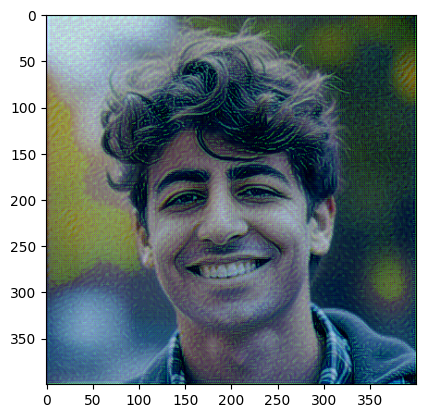

Total loss 4804.37158203125


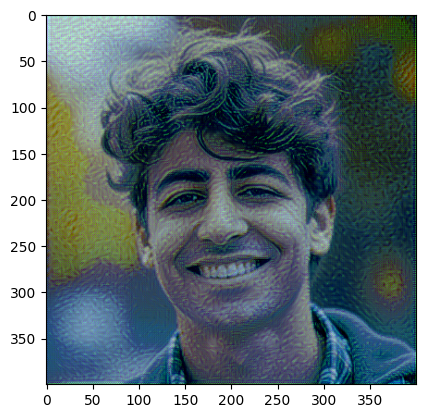

Total loss 1474.8165283203125


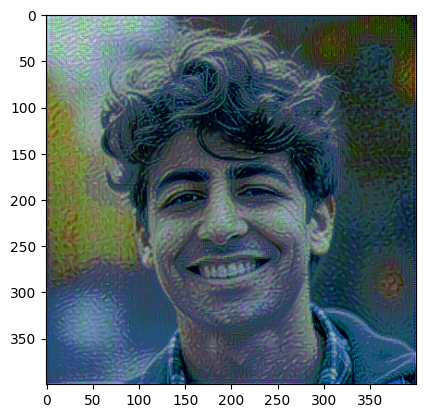

Total loss 561.1599731445312


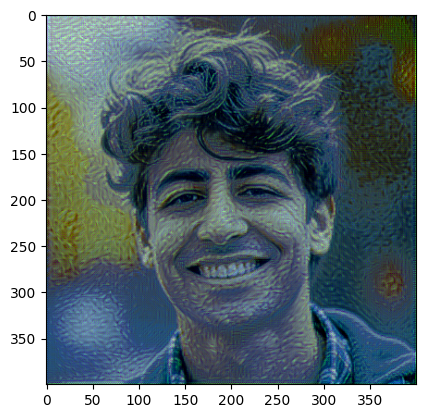

Total loss 276.0370788574219


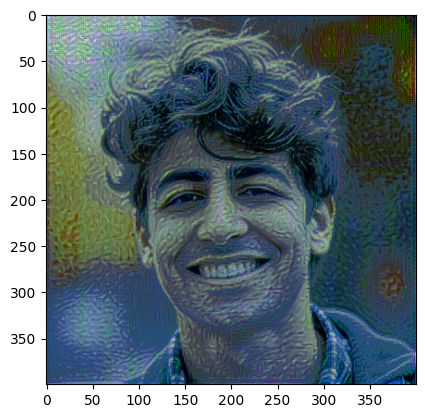

Total loss 162.4469757080078


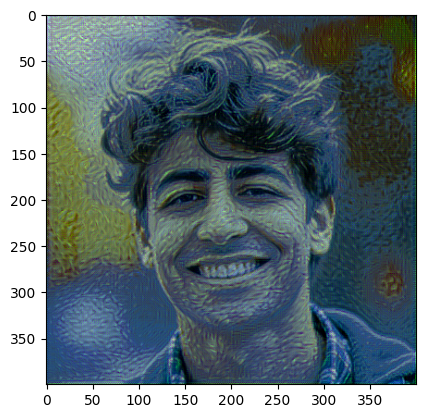

Total loss 105.28462219238281


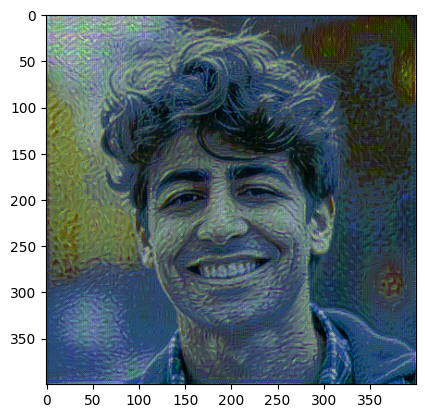

Total loss 72.69544982910156


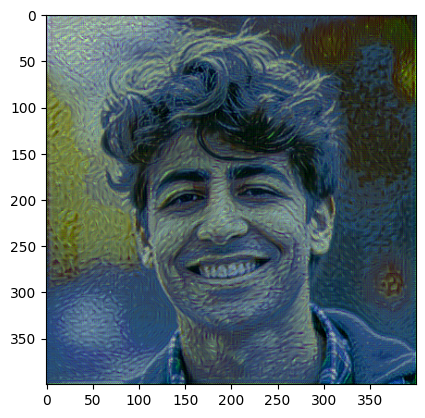

Total loss 52.562583923339844


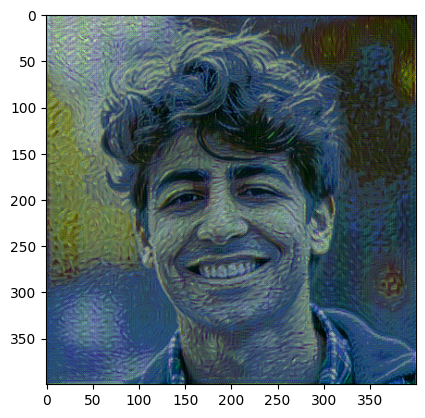

Total loss 39.16897201538086


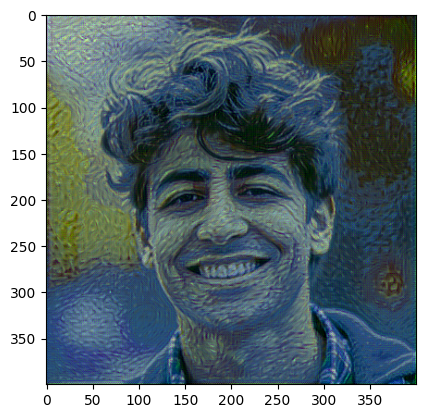

In [25]:
show_every = 500
optimizer = optim.Adam([t], lr= 0.005)
steps = 5000
content_layer = "layer3"


for step in range(1, steps+1):
    target_features = resnet_feature_extract(t, model)
    content_loss = content_loss = torch.mean((target_features[content_layer] - main_features[content_layer])**2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.size()

        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss /(d*h*w)

    total_loss = (content_weight * content_loss) + (style_weight * style_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % show_every == 0:
        print("Total loss", total_loss.item())
        plt.imshow(converter(t.cpu()))
        plt.show()

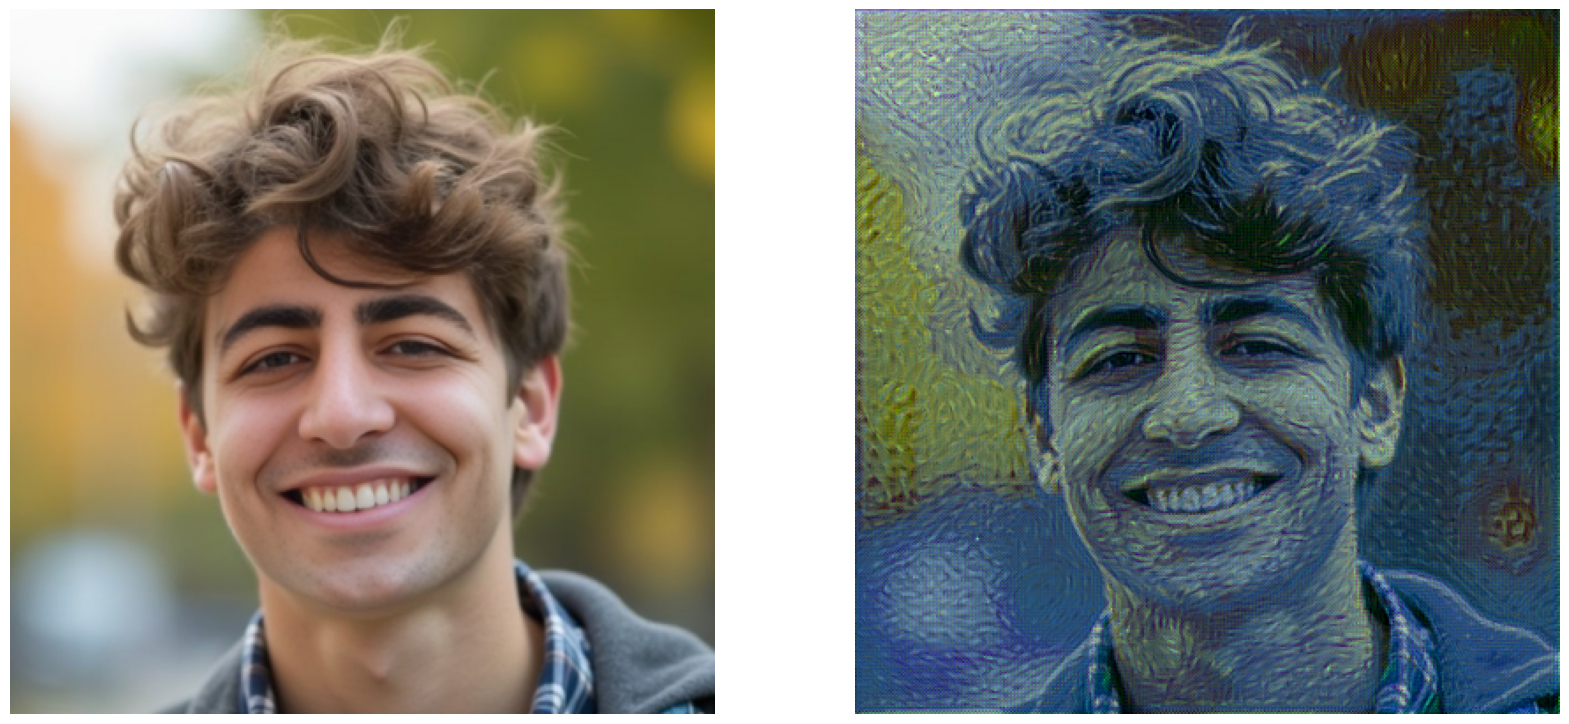

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(converter(main_img.cpu()))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(converter(t.cpu()))
plt.axis("off");